# Experimenting with Graph Inputs to PyGCN 
## References: 

- [ ] https://github.com/tkipf/pygcn
- [ ] https://github.com/DaehanKim/vgae_pytorch
- [ ] https://arxiv.org/abs/1611.07308


## Objective

This notebook is going to explain how we process graph inputs for use with GAE model. 

## Input Data

We start with a citation network dataset (in this case, Cora). The dataset is a list of publications with labels assigned based on what topic they cover. The dataset also includes information on which publications cite each other. From this, we can build a graph representing the citation network. 

The graph that represents this network is undirected (i.e. we assume that if node 1 is connected to node 2, then node 2 is also connected to node 1) and that it is unweighted (i.e. all the edges have the same weights). The graph is represented here as an adjacency matrix and a features matrix. Both of these matrices are sparse since each publication is only connected to a few other publications (generally). 

### Variables

- **N** : number of nodes in graph 
- **A** : adj matrix (size N x N) 
- **D** : degree matrix of A (i.e. a diagonal matrix where each entry represents the number of edges going into the node corresponding to that row), also size N x N
- **F** : number of features that describe each node 
- **X** : feature matrix (size N x F? paper says N x D but I don't know what D would be in this case?)
- **Z** : stochastic latent variables (size N x F) 

### Adj

The adjacency matrix contains 1's indicating where 2 publications cite each other. Kipf and Welling define the adj matrix as also having all diagonal elements set to 1 to indicate that nodes/publications are connected to themselves. This matrix is converted to $\tilde{A}$, which is a symmetrically normalized adjacency matrix computed as $\tilde{A} = D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$. 

## Overall Process

1. Import the raw data as images with 3 channels using a Dataset class
2. The Dataset class applies a Transform that converts the raw data to A and X matrices
3. The DataLoader imports the Dataset
4. Define GCN layers 
5. Define GCN encoder
6. Define GCN decoder
7. Define a training loop
8. Run training

## Utils

In [3]:
import numpy as np
import scipy.sparse as sp
from scipy.linalg import sqrtm
import torch
import matplotlib.pyplot as plt

In [ ]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

In [3]:
def load_data(path="../data/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    # ref: https://github.com/tkipf/pygcn/issues/3
    # adj is populated with 0's and 1's
    # if adj.T > adj then one of those entries is 0
    # therefore by multiplying them together, we get 0
    # the + (*) and - (*) terms where * = adj.T.multiply(adj.T > adj)
    # are for removing directed edges so that we are left with
    # an UNDIRECTED graph (i.e. edges are bidirectional)
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

In [4]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [5]:
def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [6]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

In [7]:
adj, features, labels, idx_train, idx_val, idx_test = load_data()

Loading cora dataset...


In [11]:
print("adj", adj)
print("adj type", type(adj))
print("adj[0]", adj[0])
# adj is a torch tensor in the sparse COO layout
# to create use torch.sparse.FloatTensor(indices, values, shape)
# adj is normalized!

adj tensor(indices=tensor([[   0,    8,   14,  ..., 1389, 2344, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.1667, 0.1667, 0.0500,  ..., 0.2000, 0.5000, 0.2500]),
       size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)
adj type <class 'torch.Tensor'>
adj[0] tensor(indices=tensor([[  0,   8,  14, 258, 435, 544]]),
       values=tensor([0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]),
       size=(2708,), nnz=6, layout=torch.sparse_coo)


In [14]:
print("features", features.shape)
# features is a torch array of size num_samples x num_features
# features are normalized!

features torch.Size([2708, 1433])


In [17]:
print("labels", labels.shape)
# labels is a torch array of size num_samples x 1

labels torch.Size([2708])


## How are A and X generated in example code?

A is a torch tensor (torch.sparse.FloatTensor(indices, values, shape)) generated from the COOrdinate representation for matrices using Scipy. 

X is a regular torch tensor (not sparse). 

We want to be cautious about using sparse tensors because they are in beta version according to PyTorch's website. 

## Brainstorm: How to convert our data to graph representation?

We could skip right to the end and just build A and X for each patch as torch tensors, without leveraging any of the tricks in this code. 

However, it might be interesting to see if we could build a dictionary of keys (DOK) representation with Scipy and then convert that to a torch tensor later, as the code does below. Specifically, we could do this for a **2D data representation** as follows: 

- extract all of the events from a 2D representation of the data 
- each event unique id could be a key in the dictionary
- we then iterate through every event in the patch:
    - we get the x and y coordinate of the event
    - we look for events that occur at (x +/- 1) and (y +/- 1) and add to the values for that key (if not already added)
    - we add the mean intensity, std dev intensity and event count to the feature matrix (N x 3) 
    - note that N = 32 x 32 = 1024 because we are converting ALL of the pixels to a graph
- we convert the DOK representation to a torch tensor (sparse then regular?)

In [1]:
# import an example file with 2D representation, 3 channels
# add a channel that assigns a unique ID to every pixel
# find the IDs of the nonzero pixels 
# add the 3 channels of data for these nonzero pixels to a dictionary for X
# add these IDs of nonzero pixels as keys to dictionary
# iterate through the keys
# get x and y indices of each pixel
# look for pixels that are nonzero and adjacent 
# if there are adjacent pixels, add the unique IDs of those pixels as values to that key
# convert the A and X dictionaries to tensors

In [4]:
# import an example file with 2D representation, 3 channels
input_dir = "/mnt/resource/staging/patched/smoke_data_sa_all/flattened_filtered_data/intensity_all"
filename = "xmin_0500_xmax_0532_ymin_0500_ymax_0532_t00001.npy"
myfile = np.load("{}/{}".format(input_dir, filename))

In [5]:
myfile.shape

(3, 32, 32)

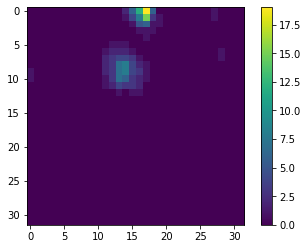

In [6]:
plt.imshow(myfile[0,:,:])
plt.colorbar()

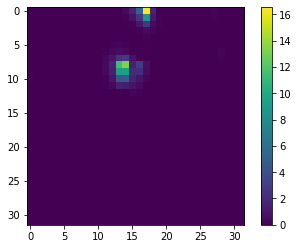

In [7]:
plt.imshow(myfile[1,:,:])
plt.colorbar()

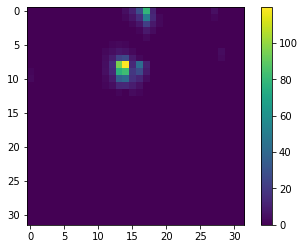

In [8]:
plt.imshow(myfile[2,:,:])
plt.colorbar()

[[[0.000e+00 1.000e+00 2.000e+00 ... 2.900e+01 3.000e+01 3.100e+01]
  [3.200e+01 3.300e+01 3.400e+01 ... 6.100e+01 6.200e+01 6.300e+01]
  [6.400e+01 6.500e+01 6.600e+01 ... 9.300e+01 9.400e+01 9.500e+01]
  ...
  [9.280e+02 9.290e+02 9.300e+02 ... 9.570e+02 9.580e+02 9.590e+02]
  [9.600e+02 9.610e+02 9.620e+02 ... 9.890e+02 9.900e+02 9.910e+02]
  [9.920e+02 9.930e+02 9.940e+02 ... 1.021e+03 1.022e+03 1.023e+03]]]


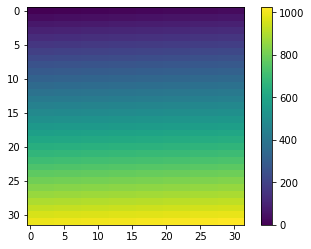

In [9]:
# add a channel that assigns a unique ID to every pixel
hei = myfile.shape[1]
wid = myfile.shape[2]
# hei = 5
# wid = 5
num_pixels = hei * wid
id_array = np.ones((hei*wid,))
for i in range(num_pixels):
    id_array[i] = i 
id_array = id_array.reshape((1, hei, wid))
print(id_array)

# add unique indices as 4th channel
myfile = np.concatenate((myfile, id_array), axis=0)
plt.imshow(myfile[3,:,:])
plt.colorbar()

In [10]:
# find the IDs of the nonzero pixels 
idx_nonzero = np.nonzero(myfile[0,:,:])
# idx_nonzero is a tuple of length 2, each entry in the tuple is the list of coordinates in one dimension
print(len(idx_nonzero))
print(idx_nonzero[0])
print(idx_nonzero[1])

2
[ 0  0  0  0  0  0  1  1  1  1  1  1  1  2  2  2  2  2  3  3  3  4  5  5
  5  6  6  6  6  6  6  7  7  7  7  7  7  7  8  8  8  8  8  8  8  9  9  9
  9  9  9  9  9 10 10 10 10 10 10 10 10 11 11 11 11 11 11 12 12 12]
[14 15 16 17 18 27 14 15 16 17 18 19 27 15 16 17 18 19 16 17 18 17 12 13
 14 11 12 13 14 15 28 11 12 13 14 15 16 28 11 12 13 14 15 16 17  0 11 12
 13 14 15 16 17  0 11 12 13 14 15 16 17 11 12 13 14 15 16 13 15 16]


In [33]:
# add the 3 channels of data for these nonzero pixels to a matrix for X
example_value = myfile[:3, idx_nonzero[0][0], idx_nonzero[1][0]]
example_value

X = np.zeros((1024,3))
print("x size", X.shape)

row_coords = idx_nonzero[0]
col_coords = idx_nonzero[1]

nonzero_entries = []

for i in range(row_coords.shape[0]):
    for j in range(col_coords.shape[0]):
        key = int(myfile[3, row_coords[i], col_coords[j]])
        X[key, :] = myfile[:3, row_coords[i], col_coords[j]]

print(X[14])
print(type(X))
print(X)

x size (1024, 3)
[2.         0.40400001 4.54526377]
<class 'numpy.ndarray'>
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [34]:
# iterate through the keys

A_dict = {}
for i in range(row_coords.shape[0]):
    for j in range(col_coords.shape[0]):
    
        # add these IDs of nonzero pixels as keys to dictionary
        key = myfile[3, row_coords[i], col_coords[j]]

        # get x and y indices of i-th nonzero pixel
        x = col_coords[j]
        y = row_coords[i]

    #     print("x, y", (x,y))

        # look for pixels that are nonzero and adjacent 
        # define the search range
        col_min = x-1
        col_max = x+1
        row_min = y-1
        row_max = y+1

    #     print("col coords", col_coords)
    #     print("row coords", row_coords)

        # the queries for finding values in search range
        col_query = (col_coords >= col_min) & (col_coords <= col_max)
        row_query = (row_coords >= row_min) & (row_coords <= row_max)

    #     all_values_in_col_range = col_coords[col_query]
    #     all_values_in_row_range = row_coords[row_query]
    #     print("all vals col range", all_values_in_col_range)
    #     print("all vals row range", all_values_in_row_range)

        # get indices of nonzero entries that fit search criteria for either x or y position
        idx_in_col_range = np.where(col_query)
        idx_in_row_range = np.where(row_query)

    #     print("idx in col range", idx_in_col_range[0].shape)
    #     print("idx in row range", idx_in_row_range[0].shape)
    #     print("idx in col range", idx_in_col_range)
    #     print("idx in row range", idx_in_row_range)

        # find the intersection of nonzero entries that fit search criteria for both x and y position
        overlap = np.intersect1d(idx_in_col_range, idx_in_row_range)
    #     print("overlap", overlap)

    #     values_in_col_range = all_values_in_col_range[overlap]
    #     values_in_row_range = all_values_in_row_range[overlap]

    #     print("col values", values_in_col_range)
    #     print("row values", values_in_row_range)

        # get row and column indices of nonzero entries that fit both search criteria
        common_idx_in_col_range = col_coords[overlap]
        common_idx_in_row_range = row_coords[overlap]

    #     print("col idx", common_idx_in_col_range)
    #     print("row idx", common_idx_in_row_range)

        # use row and column indices of nonzero entries to get unique ids
        unique_id_in_col_and_row_range = myfile[3, common_idx_in_row_range, common_idx_in_col_range]
    #     print("unique ids", unique_id_in_col_and_row_range)

        # if there are adjacent pixels, add the unique IDs of those pixels as values to that key
        A_dict[key] = list(unique_id_in_col_and_row_range)
    #     print(A_dict)
    #     break

print(A_dict)

{14.0: [14.0, 15.0, 46.0, 47.0], 15.0: [14.0, 15.0, 16.0, 46.0, 47.0, 48.0], 16.0: [15.0, 16.0, 17.0, 47.0, 48.0, 49.0], 17.0: [16.0, 17.0, 18.0, 48.0, 49.0, 50.0], 18.0: [17.0, 18.0, 49.0, 50.0, 51.0], 27.0: [27.0, 59.0], 19.0: [18.0, 50.0, 51.0], 12.0: [], 13.0: [14.0, 46.0], 11.0: [], 28.0: [27.0, 59.0], 0.0: [], 46.0: [14.0, 15.0, 46.0, 47.0, 79.0], 47.0: [14.0, 15.0, 16.0, 46.0, 47.0, 48.0, 79.0, 80.0], 48.0: [15.0, 16.0, 17.0, 47.0, 48.0, 49.0, 79.0, 80.0, 81.0], 49.0: [16.0, 17.0, 18.0, 48.0, 49.0, 50.0, 80.0, 81.0, 82.0], 50.0: [17.0, 18.0, 49.0, 50.0, 51.0, 81.0, 82.0, 83.0], 59.0: [27.0, 59.0], 51.0: [18.0, 50.0, 51.0, 82.0, 83.0], 44.0: [], 45.0: [14.0, 46.0], 43.0: [], 60.0: [27.0, 59.0], 32.0: [], 78.0: [46.0, 47.0, 79.0], 79.0: [46.0, 47.0, 48.0, 79.0, 80.0, 112.0], 80.0: [47.0, 48.0, 49.0, 79.0, 80.0, 81.0, 112.0, 113.0], 81.0: [48.0, 49.0, 50.0, 80.0, 81.0, 82.0, 112.0, 113.0, 114.0], 82.0: [49.0, 50.0, 51.0, 81.0, 82.0, 83.0, 113.0, 114.0], 91.0: [59.0], 83.0: [50.0, 5

(1024, 1024)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


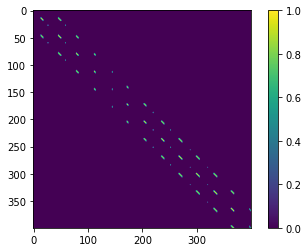

In [36]:
# convert the A dictionary to tensor
A_sparse = sp.dok_matrix((1024,1024))
print(A_sparse.shape)
for key, values in A_dict.items():
#     print("key", key)
    for val in values: 
#         print("value", val)
        # get x and y position of unique id
#         x = int(np.where(myfile[3,:,:] == val)[0])
#         y = int(np.where(myfile[3,:,:] == val)[1])
#         print("x", x)
#         print("y", y)
        A_sparse[key, val] = 1
#         print(A_sparse[val, val])
    
print(A_sparse.todense())
A_dense = A_sparse.todense()
plt.imshow(A_dense[:400, :400])
plt.colorbar()

In [29]:
from hurry.filesize import size
print(type(A_dense)) # A_dense is a numpy matrix (not an array?)
A_dense = np.asarray(A_dense)
print(type(A_dense)) # Now its a numpy array
print("Memory size of numpy array in bytes:",
      size(A_dense.size * A_dense.itemsize))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Memory size of numpy array in bytes: 8M


## Normalize and Make Symmetric the A Matrix

In [6]:
# build symmetric adjacency matrix
# ref: https://github.com/tkipf/pygcn/issues/3
# adj is populated with 0's and 1's
# if adj.T > adj then one of those entries is 0
# therefore by multiplying them together, we get 0
# the + (*) and - (*) terms where * = adj.T.multiply(adj.T > adj)
# are for removing directed edges so that we are left with
# an UNDIRECTED graph (i.e. edges are bidirectional)
# adj = A_dense
adj = np.array([[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 0]])
print("before transformation\n", adj)
# adj1 = adj + adj.T @ (adj.T > adj) - adj @ (adj.T > adj)
adj1 = adj + np.multiply(adj.T, (adj.T > adj)) - np.multiply(adj, (adj.T > adj))
print("after transformation\n", adj1)

# THIS IS THE ORIGINAL SCRIPT - WE MATCH THESE RESULTS
adj2 = sp.coo_matrix(adj)
print("adj2 before transformation\n", adj2.todense())
adj2 = adj2 + adj2.T.multiply(adj2.T > adj2) - adj2.multiply(adj2.T > adj2)
print("adj2 after transformation\n", adj2.todense())

before transformation
 [[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]
after transformation
 [[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]
adj2 before transformation
 [[0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 0]]
adj2 after transformation
 [[0 1 0 0]
 [1 0 1 0]
 [0 1 0 1]
 [0 0 1 0]]


In [7]:
# normalize A
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

In [10]:
A = adj1

# add 1's along the diagonal of A
A = A + np.eye(A.shape[0])
print("A not normalized\n", A)

rowsum = A.sum(axis=0)
print("rowsum", rowsum)
D = np.diagflat(rowsum)
print("diagonal rowsum\n", D)
D_inv = np.linalg.inv(sqrtm(D))
# D_inv = np.linalg.inv(D)

print("sqrt inverse of D\n", D_inv)
A_tilde = D_inv.T @ A @ D_inv
# A_tilde = np.dot(D_inv, A)
print("normalized A\n", A_tilde)


# COMPARE AGAINST THE ORIGINAL PAPER'S RESULTS
adj3 = adj2 + sp.eye(adj2.shape[0])
print("adj2 before normalization\n", adj3.todense())
adj3_tilde = normalize(adj3)
print("adj2 after normalization\n", adj3_tilde.todense())



A not normalized
 [[1. 1. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]]
rowsum [2. 3. 3. 2.]
diagonal rowsum
 [[2. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 3. 0.]
 [0. 0. 0. 2.]]
sqrt inverse of D
 [[0.70710678 0.         0.         0.        ]
 [0.         0.57735027 0.         0.        ]
 [0.         0.         0.57735027 0.        ]
 [0.         0.         0.         0.70710678]]
normalized A
 [[0.5        0.40824829 0.         0.        ]
 [0.40824829 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.33333333 0.40824829]
 [0.         0.         0.40824829 0.5       ]]
adj2 before normalization
 [[1. 1. 0. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 1.]
 [0. 0. 1. 1.]]
adj2 after normalization
 [[0.5        0.5        0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.5        0.5       ]]


In [20]:
def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return adj_normalized.todense()

In [14]:
def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

In [21]:
# MY RESULTS MATCH VGAE_PYTORCH REPO, I'M GOING TO PROCEED WITH THIS BECAUSE ITS THE MATHEMATICALLY CORRECT DEFINITION
adj2_tilde = preprocess_graph(adj2)
print(adj2_tilde)

[[0.5        0.40824829 0.         0.        ]
 [0.40824829 0.33333333 0.33333333 0.        ]
 [0.         0.33333333 0.33333333 0.40824829]
 [0.         0.         0.40824829 0.5       ]]


### TODO
- [ ] Are the GCN layers presented here the same as in the GVAE repo? 
- [ ] implement the GCN layers
- [ ] implement the encoder and decoder
- [ ] implement the training loop
- [ ] generate my own graphs

### Conceptual Questions: 
- [ ] this works on one large graph - how would I train on lots of smaller graphs? 
- [ ] why does gVAE worry about graph rotational invariance but I do not with GVAE? 